<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-data" data-toc-modified-id="load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#read-in-the-files" data-toc-modified-id="read-in-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read in the files</a></span><ul class="toc-item"><li><span><a href="#data-from-linear-and-relu-activations" data-toc-modified-id="data-from-linear-and-relu-activations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>data from linear and relu activations</a></span></li></ul></li><li><span><a href="#create-pandas-table" data-toc-modified-id="create-pandas-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>create pandas table</a></span></li></ul></li><li><span><a href="#filter-out-bad-training-losses" data-toc-modified-id="filter-out-bad-training-losses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>filter out bad training losses</a></span></li><li><span><a href="#determine-the-lambda-parameter-that-gets-the-best-validation-MSE-for-each-(r,n,L)" data-toc-modified-id="determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>determine the lambda parameter that gets the best test MSE for each (r,n,L)</a></span></li><li><span><a href="#Generalization-MSE" data-toc-modified-id="Generalization-MSE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generalization MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Out-of-Distribution-MSE" data-toc-modified-id="Out-of-Distribution-MSE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Out of Distribution MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Active-Subspace" data-toc-modified-id="Active-Subspace-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Active Subspace</a></span><ul class="toc-item"><li><span><a href="#evaluate-gradients-and-compute-singular-values-and-active-subspaces" data-toc-modified-id="evaluate-gradients-and-compute-singular-values-and-active-subspaces-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>evaluate gradients and compute singular values and active subspaces</a></span></li><li><span><a href="#plot-of-singular-values" data-toc-modified-id="plot-of-singular-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>plot of singular values</a></span></li></ul></li><li><span><a href="#determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)" data-toc-modified-id="determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>determine the L parameter that gets the best test MSE for each (r,n)</a></span></li><li><span><a href="#Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers" data-toc-modified-id="Plots-of-L-vs-Validation-error-and-n-vs-Generalization-metrics-with/without-linear-layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots of L vs Test error and n vs Generalization metrics with/without linear layers</a></span></li><li><span><a href="#Final-Table" data-toc-modified-id="Final-Table-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Table</a></span></li><li><span><a href="#Training-Time-Plots" data-toc-modified-id="Training-Time-Plots-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Training Time Plots</a></span><ul class="toc-item"><li><span><a href="#Train-MSE-v-Epoch" data-toc-modified-id="Train-MSE-v-Epoch-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Train MSE v Epoch</a></span></li><li><span><a href="#Weight-Decay-v-Epoch" data-toc-modified-id="Weight-Decay-v-Epoch-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Weight Decay v Epoch</a></span></li><li><span><a href="#learning-rates" data-toc-modified-id="learning-rates-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>learning rates</a></span></li></ul></li></ul></div>

# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import ortho_group
from scipy.stats import linregress
from scipy import linalg as la
from torch import nn
import torch
import os
from matplotlib.lines import Line2D
from scipy.stats import sem
from mpl_toolkits import mplot3d

# load data

## read in the files

In [2]:
rnvals = [(1,64),(1,128),(1,256),(1,512),(1,1024),(1,2048),
          (2,64),(2,128),(2,256),(2,512),(2,1024),(2,2048)]
Ls = [2,3,4,5,6,7,8,9]
rs = [1,2]
wds = [1e-3,1e-4,1e-5]
labelnoise = [0,0.25,0.5,1]
epochs = 60100
job_name = "new_targets"

In [3]:
testMSEs = {}
trainMSEs = {}
weightdecays = {}
learningrates = {}
files_found_list = []
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            for ln in labelnoise:
                paramname = job_name+f"_labelnoise{ln}"+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
                if os.path.exists(paramname+"testMSE.npy"):
                    testMSEs[r,n,L,wd,ln] = np.load(paramname+"testMSE.npy",allow_pickle=True).item()
                    trainMSEs[r,n,L,wd,ln] = np.load(paramname+"trainMSEs.npy",allow_pickle=True)
                    weightdecays[r,n,L,wd,ln] = np.load(paramname+"weightdecays.npy",allow_pickle=True)
                    learningrates[r,n,L,wd,ln] = np.load(paramname+"learningrates.npy",allow_pickle=True)
                    files_found_list.append((r,n,L,wd,ln))
                else:
                    print(f"{paramname+'testMSE.npy'} not found")

In [4]:
files_found_list

[(1, 64, 2, 0.001, 0),
 (1, 64, 2, 0.001, 0.25),
 (1, 64, 2, 0.001, 0.5),
 (1, 64, 2, 0.001, 1),
 (1, 64, 2, 0.0001, 0),
 (1, 64, 2, 0.0001, 0.25),
 (1, 64, 2, 0.0001, 0.5),
 (1, 64, 2, 0.0001, 1),
 (1, 64, 2, 1e-05, 0),
 (1, 64, 2, 1e-05, 0.25),
 (1, 64, 2, 1e-05, 0.5),
 (1, 64, 2, 1e-05, 1),
 (1, 64, 3, 0.001, 0),
 (1, 64, 3, 0.001, 0.25),
 (1, 64, 3, 0.001, 0.5),
 (1, 64, 3, 0.001, 1),
 (1, 64, 3, 0.0001, 0),
 (1, 64, 3, 0.0001, 0.25),
 (1, 64, 3, 0.0001, 0.5),
 (1, 64, 3, 0.0001, 1),
 (1, 64, 3, 1e-05, 0),
 (1, 64, 3, 1e-05, 0.25),
 (1, 64, 3, 1e-05, 0.5),
 (1, 64, 3, 1e-05, 1),
 (1, 64, 4, 0.001, 0),
 (1, 64, 4, 0.001, 0.25),
 (1, 64, 4, 0.001, 0.5),
 (1, 64, 4, 0.001, 1),
 (1, 64, 4, 0.0001, 0),
 (1, 64, 4, 0.0001, 0.25),
 (1, 64, 4, 0.0001, 0.5),
 (1, 64, 4, 0.0001, 1),
 (1, 64, 4, 1e-05, 0),
 (1, 64, 4, 1e-05, 0.25),
 (1, 64, 4, 1e-05, 0.5),
 (1, 64, 4, 1e-05, 1),
 (1, 64, 5, 0.001, 0),
 (1, 64, 5, 0.001, 0.25),
 (1, 64, 5, 0.001, 0.5),
 (1, 64, 5, 0.001, 1),
 (1, 64, 5, 0.0001

In [5]:
def Llayers(L,d=20,width=1000):
    #construct L-1 linear layers; bias term only on last linear layer
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
files_found_list = []
models = {}
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            for ln in labelnoise:
                paramname = job_name+f"_labelnoise{ln}/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
                if os.path.exists(paramname+"model.pt"):
                    models[r,n,L,wd,ln] = Llayers(L,width=1000)
                    models[r,n,L,wd,ln].to(device)
                    if torch.cuda.is_available():
                        models[r,n,L,wd,ln].load_state_dict(torch.load(paramname+"model.pt"))
                    else:
                        models[r,n,L,wd,ln].load_state_dict(torch.load(paramname+"model.pt"),map_location=torch.device('cpu'))
                    models[r,n,L,wd,ln].eval()
                    files_found_list.append((r,n,L,wd,ln))
                else:
                    print(paramname+"model.pt","not found")

In [8]:
files_found_list

[(1, 64, 2, 0.001, 0),
 (1, 64, 2, 0.001, 0.25),
 (1, 64, 2, 0.001, 0.5),
 (1, 64, 2, 0.001, 1),
 (1, 64, 2, 0.0001, 0),
 (1, 64, 2, 0.0001, 0.25),
 (1, 64, 2, 0.0001, 0.5),
 (1, 64, 2, 0.0001, 1),
 (1, 64, 2, 1e-05, 0),
 (1, 64, 2, 1e-05, 0.25),
 (1, 64, 2, 1e-05, 0.5),
 (1, 64, 2, 1e-05, 1),
 (1, 64, 3, 0.001, 0),
 (1, 64, 3, 0.001, 0.25),
 (1, 64, 3, 0.001, 0.5),
 (1, 64, 3, 0.001, 1),
 (1, 64, 3, 0.0001, 0),
 (1, 64, 3, 0.0001, 0.25),
 (1, 64, 3, 0.0001, 0.5),
 (1, 64, 3, 0.0001, 1),
 (1, 64, 3, 1e-05, 0),
 (1, 64, 3, 1e-05, 0.25),
 (1, 64, 3, 1e-05, 0.5),
 (1, 64, 3, 1e-05, 1),
 (1, 64, 4, 0.001, 0),
 (1, 64, 4, 0.001, 0.25),
 (1, 64, 4, 0.001, 0.5),
 (1, 64, 4, 0.001, 1),
 (1, 64, 4, 0.0001, 0),
 (1, 64, 4, 0.0001, 0.25),
 (1, 64, 4, 0.0001, 0.5),
 (1, 64, 4, 0.0001, 1),
 (1, 64, 4, 1e-05, 0),
 (1, 64, 4, 1e-05, 0.25),
 (1, 64, 4, 1e-05, 0.5),
 (1, 64, 4, 1e-05, 1),
 (1, 64, 5, 0.001, 0),
 (1, 64, 5, 0.001, 0.25),
 (1, 64, 5, 0.001, 0.5),
 (1, 64, 5, 0.001, 1),
 (1, 64, 5, 0.0001

## create pandas table

In [9]:
res = {
  "r"                                    : [r                          for r,n,L,wd,ln in files_found_list],# + [r                         for wd in wds for r,n in relu_rnvals],
  "sigma"                                : [ln                         for r,n,L,wd,ln in files_found_list],# + [ln                        for wd in wds for r,n in relu_rnvals],
  "n"                                    : [n                          for r,n,L,wd,ln in files_found_list],# + [n                         for wd in wds for r,n in relu_rnvals],
  "L"                                    : [L                          for r,n,L,wd,ln in files_found_list],# + [4                         for wd in wds for r,n in relu_rnvals],
  "lambda"                               : [wd                         for r,n,L,wd,ln in files_found_list],# + [wd                        for wd in wds for r,n in relu_rnvals],
  "Learning Rate"                        : [learningrates[r,n,L,wd,ln] for r,n,L,wd,ln in files_found_list],# + [RELUlearningrates[r,n][4][wd] for wd in wds for r,n in relu_rnvals],
  "Train MSE"                            : [trainMSEs[r,n,L,wd,ln]     for r,n,L,wd,ln in files_found_list],# + [RELUtrainMSEs[r,n][4][wd]     for wd in wds for r,n in relu_rnvals],
  "Weight Decay"                         : [weightdecays[r,n,L,wd,ln]  for r,n,L,wd,ln in files_found_list],# + [RELUweightdecays[r,n][4][wd]  for wd in wds for r,n in relu_rnvals],
  "Model"                                : [models[r,n,L,wd,ln]        for r,n,L,wd,ln in files_found_list],# + [RELUmodels[r,n,4,wd]          for wd in wds for r,n in relu_rnvals],
  "Test MSE"                             : [testMSEs[r,n,L,wd,ln]      for r,n,L,wd,ln in files_found_list],# + [RELUtestMSEs[r,n][4][wd].item()      for wd in wds for r,n in relu_rnvals],
  "Activations"                          : ["linear and relu"          for r,n,L,wd,ln in files_found_list],# + ["relu only"         for wd in wds for r,n in relu_rnvals]
}
res = pd.DataFrame(res)
res["Final Train MSE"] = [r[-1] for r in res["Train MSE"]]
res["Final Weight Decay"] = [r[-1] for r in res["Weight Decay"]]
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,linear and relu,1.341431e-05,224.599670
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,linear and relu,5.777340e-06,232.962372
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,linear and relu,2.933852e-06,243.854279
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,linear and relu,8.222866e-07,270.989899
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,linear and relu,5.553246e-08,226.878784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,linear and relu,8.801726e-01,1423.843750
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,linear and relu,4.186356e-06,793.465820
1149,2,0.25,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9806905, 3.2087455, 3.1139393, 3.2826471, 3...","[29418.32, 29405.709, 29402.227, 29400.758, 29...","[Linear(in_features=20, out_features=1000, bia...",0.079065,linear and relu,4.259164e-02,2450.782715
1150,2,0.50,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.1494136, 3.4205222, 3.316286, 3.436524, 3.2...","[29417.41, 29405.28, 29401.941, 29399.887, 293...","[Linear(in_features=20, out_features=1000, bia...",0.442928,linear and relu,1.006398e-01,4212.969727


# filter out bad training losses

In [10]:
trainMSE_threshold = 1e-2

In [11]:
res[res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]] #TODO is this reasonable?

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay


In [12]:
res = res[res["Final Train MSE"] < trainMSE_threshold + res["sigma"]]
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,linear and relu,1.341431e-05,224.599670
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,linear and relu,5.777340e-06,232.962372
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,linear and relu,2.933852e-06,243.854279
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,linear and relu,8.222866e-07,270.989899
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,linear and relu,5.553246e-08,226.878784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,linear and relu,8.801726e-01,1423.843750
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,linear and relu,4.186356e-06,793.465820
1149,2,0.25,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9806905, 3.2087455, 3.1139393, 3.2826471, 3...","[29418.32, 29405.709, 29402.227, 29400.758, 29...","[Linear(in_features=20, out_features=1000, bia...",0.079065,linear and relu,4.259164e-02,2450.782715
1150,2,0.50,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.1494136, 3.4205222, 3.316286, 3.436524, 3.2...","[29417.41, 29405.28, 29401.941, 29399.887, 293...","[Linear(in_features=20, out_features=1000, bia...",0.442928,linear and relu,1.006398e-01,4212.969727


# generate data function


In [13]:
def gen_data(datasetsize,r,seed,std,labelnoiseseed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False):

    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
    testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    #out of distribution datagen
    if ood:
        trainX *= 2 #now distributed as U[-1, 1]
        testX *= 2 #now distributed as U[-1, 1]
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    U = np.load(job_name+f"_labelnoise{std}/r{r}U.npy")
    Sigma = np.load(job_name+f"_labelnoise{std}/r{r}Sigma.npy")
    V = np.load(job_name+f"_labelnoise{std}/r{r}V.npy")
    A = np.load(job_name+f"_labelnoise{std}/r{r}A.npy")
    B = np.load(job_name+f"_labelnoise{std}/r{r}B.npy")
    #create functions
    np.random.seed(labelnoiseseed) #set seed for data generation
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x    
        eps = std*np.random.randn(x.shape[1])    
        return g(z) + eps
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


# Validation MSE


## generate data


In [14]:
validationY = {}

validationsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 686 + k
        datagenseed = 1107
        print("validation size =",validationsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        validationX,validationY[r,std] = gen_data(datasetsize=validationsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed)[:2]
validationX.min(),validationX.max()


validation size = 2048 r = 1 label noise std = 0 label noise seed = 686
validation size = 2048 r = 1 label noise std = 0.25 label noise seed = 687
validation size = 2048 r = 1 label noise std = 0.5 label noise seed = 688
validation size = 2048 r = 1 label noise std = 1 label noise seed = 689
validation size = 2048 r = 2 label noise std = 0 label noise seed = 686
validation size = 2048 r = 2 label noise std = 0.25 label noise seed = 687
validation size = 2048 r = 2 label noise std = 0.5 label noise seed = 688
validation size = 2048 r = 2 label noise std = 1 label noise seed = 689


(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute squared errors


In [15]:
with torch.no_grad():
    validation = []
    normalized_validation = []
    squared_errors = []
    validation_sem = []
    validation_std = []
    for rownum, row in res.iterrows():
        std = row["sigma"]
        predY = row["Model"](validationX)
        squared_err = (predY[:,0] - validationY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],validationY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        validation.append(mse)
        sem_sqared_err = sem(squared_err)
        validation_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        validation_std.append(std_sqared_err)
        if std > 0:
            normalized_validation.append(mse/(std**2))
        else:
            normalized_validation.append(np.nan)
        squared_errors.append(squared_err)
    res["Validation MSE"] = validation
    res["Validation MSE$/\sigma^2$"] = normalized_validation
    res["Validation Squared Errors"] = squared_errors
    res["Validation SEM"] = validation_sem
    res["Validation STD of Squared Errors"] = validation_std
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Validation MSE,Validation MSE$/\sigma^2$,Validation Squared Errors,Validation SEM,Validation STD of Squared Errors
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,linear and relu,1.341431e-05,224.599670,0.016170,NaN,"[0.00016536887, 0.0005573925, 0.012136012, 0.0...",1.897143e-03,0.085834
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,linear and relu,5.777340e-06,232.962372,0.196858,3.149720,"[0.047511395, 0.42259374, 0.22228272, 0.204517...",6.768054e-03,0.306212
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,linear and relu,2.933852e-06,243.854279,0.715122,2.860486,"[1.5282708, 1.1073713, 0.43318748, 0.6494131, ...",2.324566e-02,1.051721
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,linear and relu,8.222866e-07,270.989899,2.548462,2.548462,"[0.20293018, 0.06598258, 0.001722317, 0.553334...",8.663294e-02,3.919602
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,linear and relu,5.553246e-08,226.878784,0.030106,NaN,"[0.00012912927, 0.0035010616, 0.032442354, 0.0...",2.302237e-03,0.104162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,linear and relu,8.801726e-01,1423.843750,1.071402,1.071402,"[0.26120108, 0.993265, 0.3546691, 0.5560285, 3...",3.355892e-02,1.518333
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,linear and relu,4.186356e-06,793.465820,0.000004,NaN,"[2.516783e-06, 3.7456293e-06, 1.0706799e-08, 1...",5.863627e-07,0.000027
1149,2,0.25,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9806905, 3.2087455, 3.1139393, 3.2826471, 3...","[29418.32, 29405.709, 29402.227, 29400.758, 29...","[Linear(in_features=20, out_features=1000, bia...",0.079065,linear and relu,4.259164e-02,2450.782715,0.077548,1.240770,"[0.008214801, 0.041219484, 0.04545011, 0.03442...",2.484016e-03,0.112386
1150,2,0.50,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.1494136, 3.4205222, 3.316286, 3.436524, 3.2...","[29417.41, 29405.28, 29401.941, 29399.887, 293...","[Linear(in_features=20, out_features=1000, bia...",0.442928,linear and relu,1.006398e-01,4212.969727,0.440972,1.763887,"[1.5606796, 0.10447426, 0.14012745, 0.03104909...",1.581634e-02,0.715591


# In-Distribution Generalization

## generate data

In [16]:
generalizationY = {}
generalizationsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 743 + k
        datagenseed = 555
        print("generalization size =",generalizationsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        generalizationX,generalizationY[r,std] = gen_data(datasetsize=generalizationsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed)[:2]

generalization size = 2048 r = 1 label noise std = 0 label noise seed = 743
generalization size = 2048 r = 1 label noise std = 0.25 label noise seed = 744
generalization size = 2048 r = 1 label noise std = 0.5 label noise seed = 745
generalization size = 2048 r = 1 label noise std = 1 label noise seed = 746
generalization size = 2048 r = 2 label noise std = 0 label noise seed = 743
generalization size = 2048 r = 2 label noise std = 0.25 label noise seed = 744
generalization size = 2048 r = 2 label noise std = 0.5 label noise seed = 745
generalization size = 2048 r = 2 label noise std = 1 label noise seed = 746


In [17]:
generalizationX.min(),generalizationX.max()

(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute squared errors

In [18]:
with torch.no_grad():
    generalization = []
    normalized_generalization = []
    squared_errors = []
    generalization_sem = []
    generalization_std = []
    for rownum, row in res.iterrows():
        std = row["sigma"]
        predY = row["Model"](generalizationX)
        squared_err = (predY[:,0] - generalizationY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],generalizationY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        generalization.append(mse)
        sem_sqared_err = sem(squared_err)
        generalization_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        generalization_std.append(std_sqared_err)
        if std > 0:
            normalized_generalization.append(mse/(std**2))
        else:
            normalized_generalization.append(np.nan)
        squared_errors.append(squared_err)
    res["In-Distribution Generalization"] = generalization
    res["In-Distribution Generalization$/\sigma^2$"] = normalized_generalization
    res["In-Distribution Squared Errors"] = squared_errors
    res["In-Distribution SEM"] = generalization_sem
    res["In-Distribution STD of Squared Errors"] = generalization_std

# Out-of-Distribution Generalization

## generate data

In [19]:
oodY = {}
oodsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 235 + k
        datagenseed = 333
        print("ood size =",oodsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        oodX,oodY[r,std] = gen_data(datasetsize=oodsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed,ood=True)[:2]

ood size = 2048 r = 1 label noise std = 0 label noise seed = 235
ood size = 2048 r = 1 label noise std = 0.25 label noise seed = 236
ood size = 2048 r = 1 label noise std = 0.5 label noise seed = 237
ood size = 2048 r = 1 label noise std = 1 label noise seed = 238
ood size = 2048 r = 2 label noise std = 0 label noise seed = 235
ood size = 2048 r = 2 label noise std = 0.25 label noise seed = 236
ood size = 2048 r = 2 label noise std = 0.5 label noise seed = 237
ood size = 2048 r = 2 label noise std = 1 label noise seed = 238


In [20]:
oodX.min(),oodX.max()

(tensor(-1.0000, device='cuda:0'), tensor(0.9999, device='cuda:0'))

## compute squared errors

In [21]:
with torch.no_grad():
    ood = []
    normalized_ood = []
    squared_errors = []
    ood_sem = []
    ood_std = []
    for rownum, row in res.iterrows():
        std = row["sigma"]
        predY = row["Model"](oodX)
        squared_err = (predY[:,0] - oodY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],oodY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        ood.append(mse)
        sem_sqared_err = sem(squared_err)
        ood_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        ood_std.append(std_sqared_err)
        if std > 0:
            normalized_ood.append(mse/(std**2))
        else:
            normalized_ood.append(np.nan)
        squared_errors.append(squared_err)
    res["Out-of-Distribution Generalization"] = ood
    res["Out-of-Distribution Generalization$/\sigma^2$"] = normalized_ood
    res["Out-of-Distribution Squared Errors"] = squared_errors
    res["Out-of-Distribution SEM"] = ood_sem
    res["Out-of-Distribution STD of Squared Errors"] = ood_std

# Check that most or all ReLU hyperplanes intersect the support of the distributions of the tests

r = 1

TOTALS:
~~~~~~~
 R2-cost contribution          129.775677
|b| / ||w||_1                   1.718445
# training active,n=64        743.000000
% training active,n=64         11.609375
# training active,n=128      1468.000000
% training active,n=128        11.468750
# training active,n=256      2894.000000
% training active,n=256        11.304688
# training active,n=512      5796.000000
% training active,n=512        11.320312
# training active,n=1024    11592.000000
% training active,n=1024       11.320312
# training active,n=2048    23158.000000
% training active,n=2048       11.307617
# validation active         23138.000000
% validation active            11.297852
# generalization active     23137.000000
% generalization active        11.297363
# ood active                23299.000000
% ood active                   11.376465
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,"# training active,n=64","% training active,n=64","# training active,n=128","% training active,n=128","# training active,n=256","% training active,n=256","# training active,n=512","% training active,n=512","# training active,n=1024","% training active,n=1024","# training active,n=2048","% training active,n=2048",# validation active,% validation active,# generalization active,% generalization active,# ood active,% ood active
0,5.239101,0.017410,18,0.281250,45,0.351562,105,0.410156,204,0.398438,425,0.415039,865,0.422363,894,0.436523,868,0.423828,956,0.466797
1,0.780412,0.025086,46,0.718750,84,0.656250,156,0.609375,318,0.621094,634,0.619141,1252,0.611328,1215,0.593262,1247,0.608887,1118,0.545898
2,0.438060,0.113275,9,0.140625,14,0.109375,23,0.089844,52,0.101562,118,0.115234,231,0.112793,216,0.105469,225,0.109863,563,0.274902
3,8.485826,0.009074,45,0.703125,79,0.617188,141,0.550781,288,0.562500,561,0.547852,1108,0.541016,1078,0.526367,1115,0.544434,1060,0.517578
4,5.722474,0.000186,37,0.578125,66,0.515625,126,0.492188,260,0.507812,514,0.501953,1028,0.501953,992,0.484375,1029,0.502441,1027,0.501465
5,9.581510,0.001485,25,0.390625,59,0.460938,127,0.496094,247,0.482422,502,0.490234,1002,0.489258,1045,0.510254,1003,0.489746,1013,0.494629
6,9.344744,0.002883,39,0.609375,69,0.539062,130,0.507812,268,0.523438,527,0.514648,1053,0.514160,1018,0.497070,1054,0.514648,1041,0.508301
7,11.159105,0.007599,44,0.687500,75,0.585938,137,0.535156,283,0.552734,552,0.539062,1095,0.534668,1059,0.517090,1099,0.536621,1054,0.514648
8,0.406547,0.019168,29,0.453125,54,0.421875,103,0.402344,217,0.423828,436,0.425781,855,0.417480,836,0.408203,883,0.431152,937,0.457520
9,5.524434,0.003632,40,0.625000,71,0.554688,132,0.515625,271,0.529297,533,0.520508,1064,0.519531,1024,0.500000,1066,0.520508,1042,0.508789


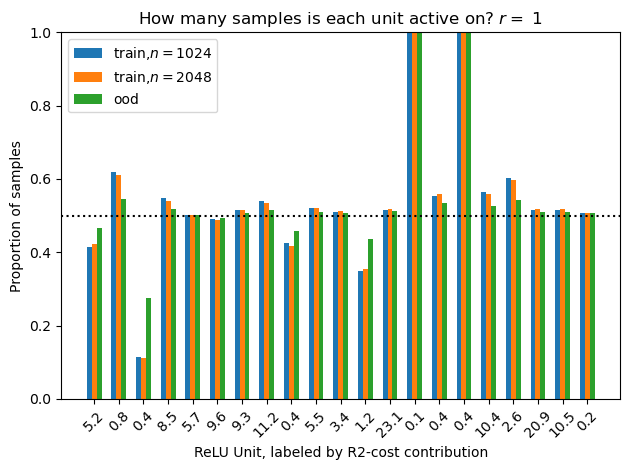

r = 2

TOTALS:
~~~~~~~
 R2-cost contribution          223.147503
|b| / ||w||_1                   0.230783
# training active,n=64        672.000000
% training active,n=64         10.500000
# training active,n=128      1333.000000
% training active,n=128        10.414062
# training active,n=256      2674.000000
% training active,n=256        10.445312
# training active,n=512      5353.000000
% training active,n=512        10.455078
# training active,n=1024    10675.000000
% training active,n=1024       10.424805
# training active,n=2048    21379.000000
% training active,n=2048       10.438965
# validation active         21284.000000
% validation active            10.392578
# generalization active     21298.000000
% generalization active        10.399414
# ood active                21360.000000
% ood active                   10.429688
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,"# training active,n=64","% training active,n=64","# training active,n=128","% training active,n=128","# training active,n=256","% training active,n=256","# training active,n=512","% training active,n=512","# training active,n=1024","% training active,n=1024","# training active,n=2048","% training active,n=2048",# validation active,% validation active,# generalization active,% generalization active,# ood active,% ood active
0,2.021811,0.021495,28,0.437500,50,0.390625,98,0.382812,206,0.402344,398,0.388672,775,0.378418,782,0.381836,784,0.382812,925,0.451660
1,0.402139,0.043486,42,0.656250,90,0.703125,181,0.707031,357,0.697266,725,0.708008,1449,0.707520,1446,0.706055,1453,0.709473,1220,0.595703
2,1.278993,0.023220,27,0.421875,52,0.406250,107,0.417969,206,0.402344,384,0.375000,808,0.394531,753,0.367676,787,0.384277,887,0.433105
3,4.191544,0.007405,29,0.453125,56,0.437500,124,0.484375,232,0.453125,483,0.471680,995,0.485840,976,0.476562,968,0.472656,982,0.479492
4,21.394932,0.013318,37,0.578125,76,0.593750,152,0.593750,297,0.580078,578,0.564453,1185,0.578613,1138,0.555664,1165,0.568848,1046,0.510742
5,9.869071,0.007666,33,0.515625,67,0.523438,130,0.507812,271,0.529297,558,0.544922,1082,0.528320,1126,0.549805,1102,0.538086,1080,0.527344
6,5.596780,0.010253,36,0.562500,72,0.562500,147,0.574219,291,0.568359,568,0.554688,1164,0.568359,1118,0.545898,1145,0.559082,1035,0.505371
7,9.045827,0.005964,33,0.515625,71,0.554688,146,0.570312,282,0.550781,573,0.559570,1148,0.560547,1108,0.541016,1102,0.538086,1045,0.510254
8,3.535087,0.006273,35,0.546875,68,0.531250,141,0.550781,271,0.529297,536,0.523438,1102,0.538086,1089,0.531738,1068,0.521484,1037,0.506348
9,9.782236,0.000971,29,0.453125,63,0.492188,128,0.500000,259,0.505859,522,0.509766,1071,0.522949,1030,0.502930,1059,0.517090,1002,0.489258


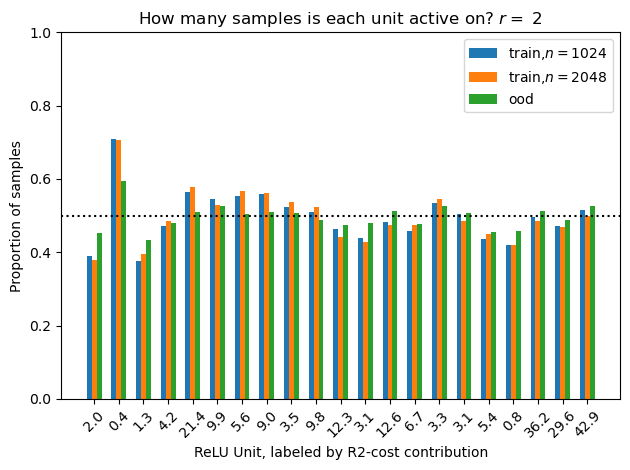

In [22]:
for r in rs:
    print("r =",r)
    U = np.load(job_name+f"_labelnoise0/r{r}U.npy")
    Sigma = np.load(job_name+f"_labelnoise0/r{r}Sigma.npy")
    V = np.load(job_name+f"_labelnoise0/r{r}V.npy")
    A = np.load(job_name+f"_labelnoise0/r{r}A.npy")
    B = np.load(job_name+f"_labelnoise0/r{r}B.npy")
    W = (U*Sigma)@V.T
    rowwise1norms = np.linalg.norm(W,axis=1,ord=1)
    ratios = np.abs(B) / np.linalg.norm(W,axis=1,ord=1)
    rowwise2norms = np.linalg.norm(W,axis=1,ord=2)
    units = pd.DataFrame({"R2-cost contribution":np.abs(A)*rowwise2norms,"|b| / ||w||_1":ratios})
    # units["[-1/2,1/2]"] = ratios <= 1/2
    # units["[-1,1] but not [-1/2,1/2]"] = (1/2 < ratios) * (ratios <= 1)
    # units["not [-1,1]"] = ratios > 1

    datasetsize = 2048
    trainX = gen_data(datasetsize=datasetsize,r=r,seed=1,std=0,labelnoiseseed=0)[0]
    for n in res.n.unique():
        units[f"# training active,n={n}"] = ((W@trainX[:n].cpu().numpy().T).T + B > 0).sum(axis=0)
        units[f"% training active,n={n}"] = units[f"# training active,n={n}"] / n
    units["# validation active"] = ((W@validationX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% validation active"] = units["# validation active"] / datasetsize
    units["# generalization active"] = ((W@generalizationX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% generalization active"] = units["# generalization active"] / datasetsize
    units["# ood active"] = ((W@oodX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% ood active"] = units["# ood active"] / datasetsize

    print("\nTOTALS:\n~~~~~~~\n",units.sum())
    print("\nunit-wise table:\n~~~~~~~\n")
    display(units)
    shift = -0.2
    width = 0.2
    for n in res.n.unique():
        if n >= 1024:
            plt.bar(units.index+shift,units[f"% training active,n={n}"],label=f"train,$n={n}$",width=width,tick_label=units["R2-cost contribution"].round(1))
            shift += width
    # plt.bar(units.index,units["% generalization active"],label="gen",width=width)
    plt.bar(units.index+shift,units["% ood active"],label="ood",width=width)
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.title(f"How many samples is each unit active on? $r =$ {r}")
    plt.xlabel("ReLU Unit, labeled by R2-cost contribution")
    plt.ylabel("Proportion of samples")
    plt.axhline(0.5,linestyle=":",color="k")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"samples_active_by_unit_r{r}")
    plt.show()


# Active Subspace

## evaluate gradients and compute singular values and active subspaces

In [23]:
grads = []
sv = []
active_subspace = []
subspace_dist = []

for rownum, row in res.iterrows():
    #compute ground truth active subspace
    funcseed = 42
    d = 20
    k = d+1
    ln = row['sigma']
    if int(ln) == ln:
        ln = int(ln)
    U = np.load(job_name+f"_labelnoise{ln}/r{row['r']}U.npy")
    Sigma = np.load(job_name+f"_labelnoise{ln}/r{row['r']}Sigma.npy")
    V = np.load(job_name+f"_labelnoise{ln}/r{row['r']}V.npy")
    W = np.load(job_name+f"_labelnoise{ln}/r{row['r']}W.npy")
    A = np.load(job_name+f"_labelnoise{ln}/r{row['r']}A.npy")
    B = np.load(job_name+f"_labelnoise{ln}/r{row['r']}B.npy")

    #evaluate gradients
    generalizationX.requires_grad = True
    predY = row["Model"](generalizationX)
    grad = torch.autograd.grad(predY, generalizationX,
                            grad_outputs=torch.ones_like(predY),
                            create_graph=True)[0].detach().cpu().numpy()
    grads.append(grad)
    #compute active subspace and singular values
    Uhat,Shat,VhatT = np.linalg.svd(grad)
    Vhat = VhatT.T[:,:row["r"]] #form the basis for the active subspace
    active_subspace.append(Vhat)
    sv.append(Shat)

    subspace_dist.append(np.linalg.norm(V@V.T - Vhat@Vhat.T,2))

res["Gradient Evaluations"] = grads
res["Gradient Singular Values"] = sv
res["Active Subspace"] = active_subspace
res["Active Subspace Distance"] = subspace_dist
res["Principal Angle (Degrees)"] = np.degrees(np.arcsin(res["Active Subspace Distance"]))

res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,...,0.740137,NaN,"[0.060264908, 0.0012339343, 0.021359995, 0.022...",0.068111,3.081603,"[[-0.010868655, 0.0986223, -6.322067, -1.83362...","[968.32874, 11.143186, 3.0303738, 1.7729323, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437198
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,...,1.495525,23.928400,"[1.9390666, 0.7184156, 0.42176837, 0.045138862...",0.081860,3.703672,"[[0.12141563, 0.108319394, -6.140541, -1.78913...","[946.8696, 21.600866, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.59536874],...",0.046553,2.668236
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,...,2.934705,11.738821,"[5.900305, 0.071930945, 2.444656, 0.31099224, ...",0.106424,4.815018,"[[0.16980669, 0.03534209, -5.7435164, -1.92896...","[927.63873, 39.97266, 27.72852, 25.27948, 16.0...","[[-0.0153085105], [-0.019875197], [0.5910878],...",0.086960,4.988720
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,...,8.182631,8.182631,"[21.524408, 8.169591, 1.6052701, 0.00016028834...",0.274457,12.417486,"[[0.21086662, -0.38957053, -6.2587175, -2.3609...","[900.4196, 79.50415, 55.996624, 49.58121, 23.3...","[[-0.03380721], [-0.022455964], [0.5842638], [...",0.166716,9.596907
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,...,0.928619,NaN,"[0.5423617, 0.00019513807, 0.10284095, 0.03414...",0.068483,3.098423,"[[-0.018078366, 0.014159503, -6.2632456, -1.76...","[960.09735, 11.421271, 9.020983, 3.892466, 3.2...","[[0.0042218138], [-0.01283936], [0.59729654], ...",0.014436,0.827163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,...,1.990985,1.990985,"[3.3343883, 2.418404, 0.14265403, 0.24279521, ...",0.078069,3.532124,"[[-0.001978755, -0.3709963, -0.4465882, -1.091...","[1026.5328, 549.67456, 5.1748793e-05, 3.692153...","[[0.14173429, 0.25191653], [-0.029247671, 0.04...",0.023564,1.350258
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,...,0.000010,NaN,"[9.278334e-06, 4.7799003e-06, 4.0538282e-07, 8...",0.000001,0.000065,"[[0.13671446, -0.19189572, -0.12958246, -0.475...","[1025.1527, 544.2891, 3.2445376e-05, 3.0318157...","[[-0.1463696, 0.2493285], [0.030716158, 0.0494...",0.000103,0.005879
1149,2,0

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [24]:
validationmse_vs_lambda = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                           0.00001   0.00010   0.00100
r sigma n    L Activations                                  
1 0.0   64   2 linear and relu  0.458752  0.030106  0.016170
             3 linear and relu  0.070858  0.002051  0.018850
             4 linear and relu  0.190729  0.001041  0.000932
             5 linear and relu  0.564625  0.000791  0.000715
             6 linear and relu  0.665944  0.008138  0.000706
...                                  ...       ...       ...
2 1.0   2048 5 linear and relu  1.581497  1.513597  1.674937
             6 linear and relu  1.515202  1.468494  2.291192
             7 linear and relu  1.469250  1.481268  1.977542
             8 linear and relu  1.489625  2.389299  1.067225
             9 linear and relu  2.366597  1.071402  1.062047

[384 rows x 3 columns]

In [25]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  sigma  n     L  Activations    
1  0.00   64    2  linear and relu    0.00100
                3  linear and relu    0.00010
                4  linear and relu    0.00100
                5  linear and relu    0.00100
                6  linear and relu    0.00100
                7  linear and relu    0.00100
                8  linear and relu    0.00100
                9  linear and relu    0.00100
          128   2  linear and relu    0.00100
                3  linear and relu    0.00010
                4  linear and relu    0.00010
                5  linear and relu    0.00010
                6  linear and relu    0.00010
                7  linear and relu    0.00010
                8  linear and relu    0.00010
                9  linear and relu    0.00010
          256   2  linear and relu    0.00100
                3  linear and relu    0.00010
                4  linear and relu    0.00010
                5  linear and relu    0.00010
                6  linear and relu    0.00010

In [26]:
mask = [row["lambda"] == bestlambda[row["r"]][row["sigma"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,...,0.740137,NaN,"[0.060264908, 0.0012339343, 0.021359995, 0.022...",0.068111,3.081603,"[[-0.010868655, 0.0986223, -6.322067, -1.83362...","[968.32874, 11.143186, 3.0303738, 1.7729323, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437198
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,...,1.495525,23.928400,"[1.9390666, 0.7184156, 0.42176837, 0.045138862...",0.081860,3.703672,"[[0.12141563, 0.108319394, -6.140541, -1.78913...","[946.8696, 21.600866, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.59536874],...",0.046553,2.668236
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,...,2.934705,11.738821,"[5.900305, 0.071930945, 2.444656, 0.31099224, ...",0.106424,4.815018,"[[0.16980669, 0.03534209, -5.7435164, -1.92896...","[927.63873, 39.97266, 27.72852, 25.27948, 16.0...","[[-0.0153085105], [-0.019875197], [0.5910878],...",0.086960,4.988720
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,...,8.182631,8.182631,"[21.524408, 8.169591, 1.6052701, 0.00016028834...",0.274457,12.417486,"[[0.21086662, -0.38957053, -6.2587175, -2.3609...","[900.4196, 79.50415, 55.996624, 49.58121, 23.3...","[[-0.03380721], [-0.022455964], [0.5842638], [...",0.166716,9.596907
14,1,0.50,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.98826, 59.507004, 59.033882, 58.570343, 58...","[3341.6108, 3341.4773, 3341.4646, 3341.5679, 3...","[Linear(in_features=20, out_features=1000, bia...",0.702132,...,3.793227,15.172909,"[2.985103, 0.31728166, 2.5259962, 0.44516867, ...",0.148085,6.699946,"[[-0.19413537, 0.115532696, -6.651881, -2.1534...","[952.0082, 61.49127, 35.12933, 24.884079, 5.07...","[[0.017059598], [0.009166015], [-0.59270257], ...",0.092160,5.287869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2,0.00,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.5473466, 2.9997199, 3.0492742, 2.9489946, 2...","[23454.771, 23450.9, 23447.709, 23445.514, 234...","[Linear(in_features=20, out_features=1000, bia...",0.000004,...,0.000008,NaN,"[2.8172508e-06, 2.09439e-06, 1.0746959e-11, 1....",0.000001,0.000055,"[[0.13522276, -0.1920157, -0.13031217, -0.4766...","[1025.3177, 544.0693, 6.414657e-05, 3.3557633e...","[[-0.14632261, 0.24937947], [0.030733839, 0.04...",0.000071,0.004081
1141,2,0.25,2048,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.920266, 3.1877692, 3.1161132, 3.227237, 3.0...","[28889.393, 28811.078, 28728.883, 28639.834, 2...","[Linear(in_features=20, out_features=1000, bia...",0.065820,...,0.097837,1.565400,"[0.026378486, 0.012234152, 0.06638206, 0.00961...",0.003759,0.170053,"[[-0.10136763, -0.2521382, -0.3171574, -0.7178...","[1017.7178, 541.12286, 3.7105132e-05, 2.919450...","[[0.14605273, 0.24945678], [-0.02976642, 0.048...",0.005782,0.331313
1

##  determine the L parameter that gets the best validation MSE for each (r,n)

In [27]:
validationmse_vs_L = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
bestL = validationmse_vs_L.idxmin(axis=1)
pd.concat((validationmse_vs_L,bestL),axis=1)

3         4         5          6  \
r sigma n    Activations                                                
1 0.00  64   linear and relu  0.002051  0.000932  0.000715   0.000706   
        128  linear and relu  0.000425  0.000206  0.000129   0.000142   
        256  linear and relu  0.000193  0.000064  0.000044   0.000055   
        512  linear and relu  0.000141  0.000071  0.000049   0.000044   
        1024 linear and relu  0.000167  0.000080  0.000056   0.000052   
        2048 linear and relu  0.000036  0.000024  0.000016   0.000017   
  0.25  64   linear and relu  0.224697  0.185447  0.255699   0.245359   
        128  linear and relu  0.148188  0.133400  0.163496   0.160736   
        256  linear and relu  0.122988  0.113307  0.112297   0.120260   
        512  linear and relu  0.107883  0.102970  0.101477   0.095003   
        1024 linear and relu  0.089619  0.092375  0.091105   0.087879   
        2048 linear and relu  0.080262  0.083260  0.078215   0.064648   
  0.50  64   linear and relu  0.783313  0.717035  1.264443   0.815497   
        128  linear and relu  0.579457  0.535103  0.569831   0.690463   
        256  linear and relu  0.462894  0.453727  0.466932   0.461573   
        512  linear and relu  0.458508  0.429270  0.411440   0.388254   
        1024 linear and relu  0.408359  0.406046  0.397854   0.377442   
        2048 linear and relu  0.361757  0.362831  0.378240   0.359715   
  1.00  64   linear and relu  2.601801  2.557591  2.582925   2.898788   
        128  linear and relu  1.883841  2.177202  2.437420   2.463614   
        256  linear and relu  1.941556  1.968394  1.941256   1.853106   
        512  linear and relu  1.681868  1.619434  1.558077   1.508190   
        1024 linear and relu  1.512130  1.482790  1.484806   1.368961   
        2048 linear and relu  1.326973  1.373954  1.378385   1.360004   
2 0.00  64   linear and relu  5.875809  5.426898  5.079772   4.451693   
        128  linear and relu  4.104005  2.649819  0.406654   0.008029   
        256  linear and relu  2.341612  0.004896  0.002348   0.001605   
        512  linear and relu  0.006677  0.001011  0.000121   0.000075   
        1024 linear and relu  0.003780  0.000052  0.000034   0.000024   
        2048 linear and relu  0.000141  0.000004  0.000003   0.000003   
  0.25  64   linear and relu  6.160335  5.858872  6.099044   3.435173   
        128  linear and relu  4.464213  3.745926  1.479362   0.901535   
        256  linear and relu  2.627613  0.225331  0.172220   0.192182   
        512  linear and relu  0.171207  0.146772  0.156958   0.127276   
        1024 linear and relu  0.124075  0.117503  0.093871   0.077334   
        2048 linear and relu  0.101410  0.073618  0.065660   0.065885   
  0.50  64   linear and relu  6.525089  6.432478  6.753846   7.406042   
        128  linear and relu  5.250669  4.500720  2.648060   2.006114   
        256  linear and relu  3.013311  0.826381  0.697024   0.637454   
        512  linear and relu  0.606715  0.558552  0.545411   0.504371   
        1024 linear and relu  0.494607  0.489334  0.459021   0.455885   
        2048 linear and relu  0.427442  0.417888  0.431165   0.342941   
  1.00  64   linear and relu  9.788889  9.554877  9.180411  11.665344   
        128  linear and relu  7.659865  6.578197  4.862251   3.909962   
        256  linear and relu  5.257462  3.103240  2.539592   2.352898   
        512  linear and relu  2.569650  2.116335  1.986572   1.858070   
        1024 linear and relu  1.754230  1.757983  1.671036   1.625674   
        2048 linear and relu  1.594637  1.555686  1.513597   1.468494   

                                     7          8          9  0  
r sigma n    Activations                                         
1 0.00  64   linear and relu  0.000597   0.000566   0.000451  9  
        128  linear and relu  0.000204   0.000138   0.000195  5  
        256  linear and relu  0.000052   0.000056   0.000049  5  
        512  linear and relu  0.000044   0.000047   0.00

In [28]:
mask = [row["L"] == bestL[row["r"]][row["sigma"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
25,1,0.25,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.176464,...,0.689151,11.026415,"[0.4667347, 0.042153805, 0.12199344, 0.1878538...",0.024729,1.118811,"[[0.020501088, -0.05495559, -5.8309736, -1.656...","[966.2452, 47.81836, 17.557428, 2.726349, 7.04...","[[-0.006823214], [-0.012062299], [0.5975432], ...",0.040257,2.307153
27,1,1.00,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.256546, 59.695442, 59.145172, 58.59809, 58...","[6009.6245, 6009.4707, 6009.6377, 6010.1157, 6...","[Linear(in_features=20, out_features=1000, bia...",2.341421,...,6.998349,6.998349,"[22.790386, 4.445868, 5.3361945, 0.086147115, ...",0.232031,10.497951,"[[0.7733323, 0.22412239, -7.091814, -3.652944,...","[956.0663, 99.418846, 85.08016, 57.991444, 3.5...","[[-0.04403937], [0.01136637], [0.59848475], [0...",0.170056,9.791063
30,1,0.50,64,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.867638, 59.306477, 58.756195, 58.20883, 57...","[6010.1333, 6010.482, 6011.1475, 6012.1177, 60...","[Linear(in_features=20, out_features=1000, bia...",0.630799,...,2.070236,8.280945,"[0.0147951795, 0.14083554, 0.70165163, 0.01803...",0.066815,3.022980,"[[0.16648221, 0.20393245, -5.148461, -1.703530...","[956.5194, 64.51156, 43.482506, 26.711407, 7.5...","[[-0.017127283], [-0.011515118], [0.5929013], ...",0.079817,4.578033
84,1,0.00,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[Linear(in_features=20, out_features=1000, bia...",0.000463,...,0.004199,NaN,"[0.00019830145, 0.002557495, 0.0011127308, 2.3...",0.000324,0.014646,"[[-0.085160956, 0.11539364, -6.4720874, -1.769...","[979.8501, 2.0589066e-05, 1.9566174e-05, 1.714...","[[0.007867968], [-0.0106611485], [0.59795225],...",0.001968,0.112732
119,1,1.00,128,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.669785, 49.001053, 48.34638, 47.70898, 47....","[3341.9082, 3342.2773, 3342.9736, 3343.984, 33...","[Linear(in_features=20, out_features=1000, bia...",1.822912,...,4.770700,4.770700,"[12.572354, 0.2359236, 4.6383657, 0.2746769, 0...",0.147449,6.671157,"[[-0.7596837, -0.17297882, -5.598423, -1.15143...","[949.2189, 87.633156, 82.270195, 45.703335, 42...","[[0.0022033257], [0.007834929], [-0.584617], [...",0.084273,4.834193
121,1,0.25,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.98911, 48.219948, 47.42537, 46.588215, 45....","[6009.2017, 6009.1367, 6010.119, 6012.009, 601...","[Linear(in_features=20, out_features=1000, bia...",0.131605,...,0.432402,6.918435,"[0.19838817, 0.093049765, 2.1856418, 0.0835787...",0.013644,0.617286,"[[-0.21968561, -0.09387066, -7.254347, -1.3654...","[977.72296, 37.782833, 23.484518, 19.228611, 1...","[[0.005142253], [-0.006265251], [0.59413105], ...",0.023298,1.334997
122,1,0.50,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.04412, 48.275063, 47.48069, 46.64352, 45.7...","[6009.19, 6009.1255, 6010.1055, 6011.992, 6014...","[Linear(in_features=20, out_features=1000, bia...",0.504148,...,1.543742,6.174968,"[2.242196, 0.9780726, 10.715942, 0.02656445, 0...",0.050130,2.268051,"[[-0.7314782, -0.08973995, -7.2499743, -1.0264...","[968.5996, 64.24758, 47.830807, 42.207794, 30....","[[0.004804929], [-0.013753345], [0.590028], [0...",0.046186,2.647226
136,1,0.00,128,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.92

In [29]:
bestLres.sort_values(by=['r','n',"sigma"])

,r,sigma,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out-of-Distribution Generalization,Out-of-Distribution Generalization$/\sigma^2$,Out-of-Distribution Squared Errors,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
84,1,0.00,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[Linear(in_features=20, out_features=1000, bia...",0.000463,...,0.004199,NaN,"[0.00019830145, 0.002557495, 0.0011127308, 2.3...",0.000324,0.014646,"[[-0.085160956, 0.11539364, -6.4720874, -1.769...","[979.8501, 2.0589066e-05, 1.9566174e-05, 1.714...","[[0.007867968], [-0.0106611485], [0.59795225],...",0.001968,0.112732
25,1,0.25,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.176464,...,0.689151,11.026415,"[0.4667347, 0.042153805, 0.12199344, 0.1878538...",0.024729,1.118811,"[[0.020501088, -0.05495559, -5.8309736, -1.656...","[966.2452, 47.81836, 17.557428, 2.726349, 7.04...","[[-0.006823214], [-0.012062299], [0.5975432], ...",0.040257,2.307153
30,1,0.50,64,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.867638, 59.306477, 58.756195, 58.20883, 57...","[6010.1333, 6010.482, 6011.1475, 6012.1177, 60...","[Linear(in_features=20, out_features=1000, bia...",0.630799,...,2.070236,8.280945,"[0.0147951795, 0.14083554, 0.70165163, 0.01803...",0.066815,3.022980,"[[0.16648221, 0.20393245, -5.148461, -1.703530...","[956.5194, 64.51156, 43.482506, 26.711407, 7.5...","[[-0.017127283], [-0.011515118], [0.5929013], ...",0.079817,4.578033
27,1,1.00,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.256546, 59.695442, 59.145172, 58.59809, 58...","[6009.6245, 6009.4707, 6009.6377, 6010.1157, 6...","[Linear(in_features=20, out_features=1000, bia...",2.341421,...,6.998349,6.998349,"[22.790386, 4.445868, 5.3361945, 0.086147115, ...",0.232031,10.497951,"[[0.7733323, 0.22412239, -7.091814, -3.652944,...","[956.0663, 99.418846, 85.08016, 57.991444, 3.5...","[[-0.04403937], [0.01136637], [0.59848475], [0...",0.170056,9.791063
136,1,0.00,128,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.925003, 48.27504, 47.552925, 46.661526, 45...","[9343.715, 9345.677, 9349.422, 9354.756, 9361....","[Linear(in_features=20, out_features=1000, bia...",0.000121,...,0.005129,NaN,"[2.831839e-05, 0.00043061387, 0.00035353936, 1...",0.000503,0.022736,"[[-0.08770335, 0.113912195, -6.4779863, -1.764...","[980.75745, 0.008349364, 0.00040444278, 8.3398...","[[0.008103928], [-0.010521636], [0.59816086], ...",0.000731,0.041885
121,1,0.25,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.98911, 48.219948, 47.42537, 46.588215, 45....","[6009.2017, 6009.1367, 6010.119, 6012.009, 601...","[Linear(in_features=20, out_features=1000, bia...",0.131605,...,0.432402,6.918435,"[0.19838817, 0.093049765, 2.1856418, 0.0835787...",0.013644,0.617286,"[[-0.21968561, -0.09387066, -7.254347, -1.3654...","[977.72296, 37.782833, 23.484518, 19.228611, 1...","[[0.005142253], [-0.006265251], [0.59413105], ...",0.023298,1.334997
122,1,0.50,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.04412, 48.275063, 47.48069, 46.64352, 45.7...","[6009.19, 6009.1255, 6010.1055, 6011.992, 6014...","[Linear(in_features=20, out_features=1000, bia...",0.504148,...,1.543742,6.174968,"[2.242196, 0.9780726, 10.715942, 0.02656445, 0...",0.050130,2.268051,"[[-0.7314782, -0.08973995, -7.2499743, -1.0264...","[968.5996, 64.24758, 47.830807, 42.207794, 30....","[[0.004804929], [-0.013753345], [0.590028], [0...",0.046186,2.647226
119,1,1.00,128,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.669785,

## What are the chosen lambda and L for each model?

In [30]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bestres.loc[:,:"lambda"].pivot_table(index=["r","sigma","n","L"],values=["lambda"]))

lambda
r sigma n    L         
1 0.00  64   2  0.00100
             9  0.00100
        128  2  0.00100
             5  0.00010
        256  2  0.00100
             5  0.00010
        512  2  0.00010
             9  0.00001
        1024 2  0.00010
             8  0.00001
        2048 2  0.00010
             8  0.00001
  0.25  64   2  0.00100
             4  0.00100
        128  2  0.00100
             4  0.00100
        256  2  0.00100
             7  0.00001
        512  2  0.00100
             9  0.00100
        1024 2  0.00100
             9  0.00100
        2048 2  0.00100
             9  0.00100
  0.50  64   2  0.00100
             4  0.00010
        128  2  0.00100
             4  0.00100
        256  2  0.00100
             7  0.00001
        512  2  0.00100
             9  0.00100
        1024 2  0.00100
             9  0.00100
        2048 2  0.00100
             9  0.00100
  1.00  64   2  0.00100
             4  0.00100
        128  2  0.00100
             3  0.00001
        256  2  0.00100
             8  0.00001
        512  2  0.00100
             8  0.00001
        1024 2  0.00100
             8  0.00001
        2048 2  0.00100
             9  0.00100
2 0.00  64   2  0.00010
             7  0.00100
        128  2  0.00100
             9  0.00100
        256  2  0.00100
             9  0.00100
        512  2  0.00100
             9  0.00010
        1024 2  0.00100
             8  0.00001
        2048 2  0.00100
             7  0.00001
  0.25  64   2  0.00010
             9  0.00001
        128  2  0.00100
             9  0.00100
        256  2  0.00010
             9  0.00100
        512  2  0.00100
             9  0.00100
        1024 2  0.00100
             8  0.00100
        2048 2  0.00100
             5  0.00100
  0.50  64   2  0.00010
             8  0.00100
        128  2  0.00100
             8  0.00100
        256  2  0.00100
             6  0.00100
        512  2  0.00100
             7  0.00010
        1024 2  0.00100
             9  0.00100
        2048 2  0.00100
             9  0.00100
  1.00  64   2  0.00100
             5  0.00001
        128  2  0.00010
             9  0.00001
        256  2  0.00100
             8  0.00001
        512  2  0.00100
             9  0.00001
        1024 2  0.00010
             9  0.00100
        2048 2  0.00100
             9  0.00100

# Plotting

In [116]:
fontname = "Times New Roman"
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## plots of all the singular values

0 0
1,64,2 [2.1397245e+01 2.4623194e-01 6.6962436e-02 3.9176639e-02 2.7920177e-02
 1.5365245e-02 1.0518795e-02 8.0341753e-03 4.3791332e-03 3.1833225e-03
 2.1691981e-03 8.1622944e-04 6.0989050e-04 3.3216338e-04 2.0764682e-04
 4.0767110e-05 3.2482581e-05 1.5382344e-05 1.3651791e-05 4.2678421e-06] 0 0
0 0
1,64,3 [2.1580151e+01 5.4735292e-02 2.4986546e-02 1.2170881e-02 7.5046648e-03
 1.6577876e-03 5.0426117e-04 2.4052861e-04 1.2748057e-04 6.4072912e-05
 2.4774223e-05 4.9216214e-06 3.0079013e-06 1.3217309e-06 9.1503642e-07
 3.0646382e-07 1.9242795e-07 1.1743163e-07 9.3481525e-08 5.9740643e-08] 0 0
0 0
1,64,4 [2.1628813e+01 8.7933370e-07 3.8444693e-07 2.2952726e-07 1.5966137e-07
 1.3412452e-07 1.2223812e-07 1.0803177e-07 8.8969770e-08 6.9514208e-08
 6.1090290e-08 5.2695921e-08 4.1517392e-08 2.8748026e-08 2.7823036e-08
 2.2420808e-08 8.6589065e-09 6.1929577e-09 4.7136628e-09 3.3359815e-09] 0 0
0 0
1,64,5 [2.1664530e+01 5.8098476e-07 4.3927045e-07 2.3981099e-07 2.0514800e-07
 1.4183993e-07 1.2

/tmp/ipykernel_879463/3251633849.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


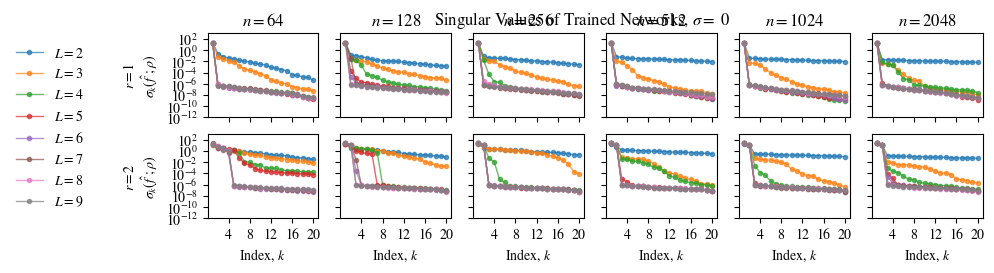

0 0
1,64,2 [2.0923061e+01 4.7731623e-01 3.2848510e-01 2.7345777e-01 2.3200530e-01
 1.0044926e-01 6.4735465e-02 4.6735667e-02 4.1192871e-02 2.8033523e-02
 1.8110814e-02 1.4201344e-02 1.2294622e-02 8.5401023e-03 7.8599583e-03
 5.6151147e-03 2.6778979e-03 2.1586274e-03 1.7372636e-03 1.1288235e-03] 0 0
0 0
1,64,3 [2.1120762e+01 8.1277418e-01 4.3553767e-01 1.8993250e-01 1.4589764e-02
 3.6647653e-03 3.0990453e-03 9.3590282e-04 3.0620731e-04 1.8558076e-04
 8.2375918e-05 5.2389307e-05 2.9673911e-05 1.0439685e-05 7.3939668e-06
 4.1909720e-06 2.6274913e-06 2.0373448e-06 5.4821510e-07 2.9181342e-07] 0 0
0 0
1,64,4 [2.1351204e+01 1.0566465e+00 3.8796803e-01 6.0244374e-02 1.5560762e-06
 9.1372755e-07 4.8757744e-07 3.7360999e-07 2.7846775e-07 2.6176579e-07
 2.2478206e-07 2.0174048e-07 1.5993150e-07 1.4231915e-07 1.2081988e-07
 1.0448507e-07 7.7100573e-08 7.3252288e-08 6.4576312e-08 4.5806054e-08] 0 0
0 0
1,64,5 [2.1502148e+01 1.4847529e+00 5.0623393e-01 1.0942608e-06 7.5352790e-07
 3.9116762e-07 2.9

/tmp/ipykernel_879463/3251633849.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


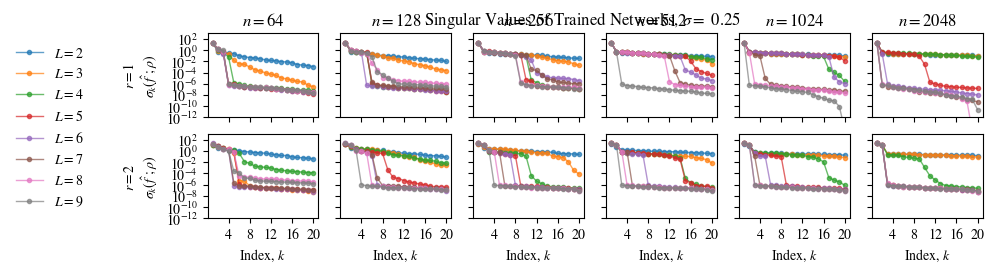

0 0
1,64,2 [2.0498114e+01 8.8327938e-01 6.1271954e-01 5.5860287e-01 3.5530925e-01
 1.7818719e-01 1.1949949e-01 8.9074239e-02 5.5983797e-02 3.7776023e-02
 3.5950921e-02 2.4497474e-02 2.1589372e-02 1.5104767e-02 1.2234320e-02
 1.0240540e-02 6.8085352e-03 5.4234853e-03 4.2912518e-03 2.6361295e-03] 0 0
0 0
1,64,3 [2.1036608e+01 1.3587779e+00 7.7625585e-01 5.4986566e-01 1.1215367e-01
 2.2411336e-04 4.3805045e-05 2.0877642e-05 1.9178795e-05 2.5439558e-06
 1.3154662e-06 8.5137572e-07 4.7237867e-07 3.1691411e-07 2.6103126e-07
 2.4818286e-07 1.9639447e-07 1.4551362e-07 1.0665602e-07 6.7626232e-08] 0 0
0 0
1,64,4 [2.11362934e+01 1.42551756e+00 9.60836709e-01 5.90244293e-01
 1.67784601e-01 5.84230758e-04 2.67042080e-04 8.26827527e-05
 4.65276789e-05 1.52693829e-05 8.41649126e-06 3.22617643e-06
 2.31713557e-06 1.52601922e-06 5.44330078e-07 4.19233999e-07
 2.71157461e-07 1.69588759e-07 1.08573396e-07 8.38416980e-08] 0 0
0 0
1,64,5 [2.12251759e+01 3.28164697e+00 1.28202081e+00 6.97893825e-07
 5.4905

/tmp/ipykernel_879463/3251633849.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


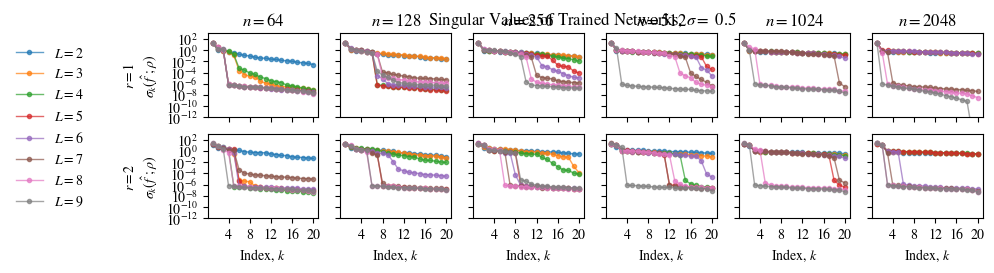

0 0
1,64,2 [1.9896650e+01 1.7568102e+00 1.2373623e+00 1.0956004e+00 5.1486486e-01
 2.6351553e-01 2.2440799e-01 1.6364115e-01 8.7633424e-02 7.9600595e-02
 6.4675048e-02 6.1927199e-02 4.1482072e-02 3.1258203e-02 1.8351998e-02
 1.6519915e-02 1.3674898e-02 1.0709269e-02 8.4582241e-03 7.4870586e-03] 0 0
0 0
1,64,3 [2.0521801e+01 1.5566394e+00 1.1936215e+00 1.0123260e+00 8.9669788e-01
 4.4757497e-01 2.2672287e-01 1.8875569e-01 1.0123217e-01 8.6201943e-02
 6.0670052e-02 5.1191848e-02 3.5704404e-02 3.3731136e-02 2.5076495e-02
 2.0234006e-02 1.5740389e-02 1.2554611e-02 1.1120572e-02 4.9804510e-03] 0 0
0 0
1,64,4 [2.11262798e+01 2.19686699e+00 1.88002372e+00 1.28144205e+00
 7.77850801e-07 6.26696931e-07 3.44296950e-07 2.87357864e-07
 2.34440606e-07 2.03296764e-07 1.73911147e-07 1.37614208e-07
 1.19159346e-07 8.28454176e-08 8.13518426e-08 6.68957014e-08
 6.07537274e-08 5.08028712e-08 4.67925290e-08 3.85163226e-08] 0 0
0 0
1,64,5 [2.12063789e+01 3.54308939e+00 2.06635785e+00 8.72490585e-01
 3.9499

/tmp/ipykernel_879463/3251633849.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


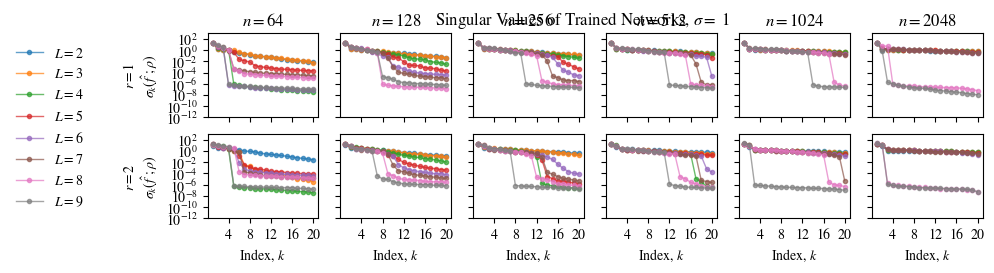

In [117]:
#all the singular values
for std in labelnoise:
    f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,2.4))
    for rownum,row in res.iterrows():
        if row['sigma'] == std:
            whichrow = np.where(row['r'] == res.r.unique())[0][0]
            whichcol = np.where(row['n'] == res.n.unique())[0][0]
            print(whichrow,whichcol)
            print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
            ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
            ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
            ax[whichrow,whichcol].set_ylim(10**-9,10**3)
            ax[0,whichcol].set_title(rf"$n={row['n']}$")
            ax[-1,whichcol].set_xlabel(rf"Index, $k$")
    plt.subplot(2,len(res.n.unique()),1)
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(-1, 1))
    leg.get_frame().set_edgecolor('b')
    leg.get_frame().set_linewidth(0.0)
    plt.subplot(2,len(res.n.unique()),1)
    plt.ylabel(r"$r=1$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
    plt.yticks([10**p for p in range(-12,3,2)])
    plt.subplot(2,len(res.n.unique()),len(res.n.unique())+1)
    plt.ylabel(r"$r=2$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
    plt.yticks([10**p for p in range(-12,3,2)])
    plt.suptitle(rf"Singular Values of Trained Networks, $\sigma =$ {std}")
    plt.tight_layout()
    plt.savefig(job_name+f"_labelnoise{std}/sv.pdf",dpi=300)#,bbox_extra_artists=(leg,), bbox_inches='tight')
    plt.show()

## Plots of L vs Validation error

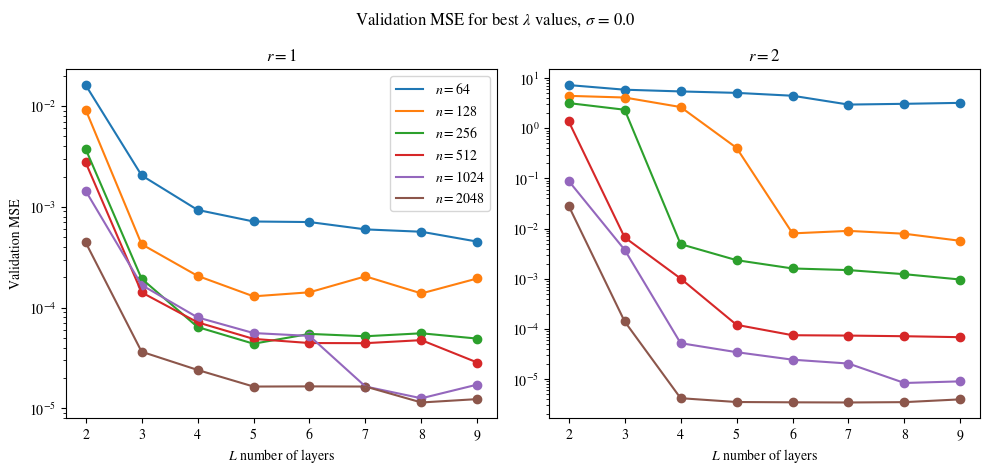

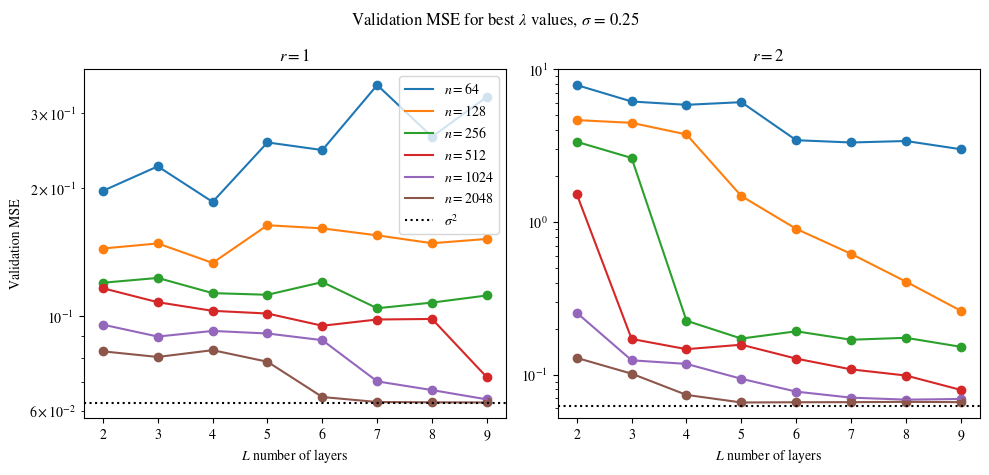

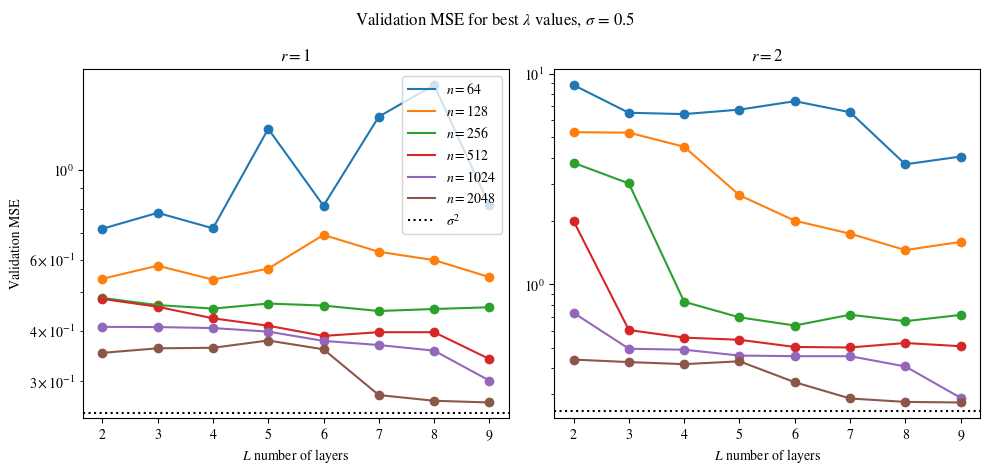

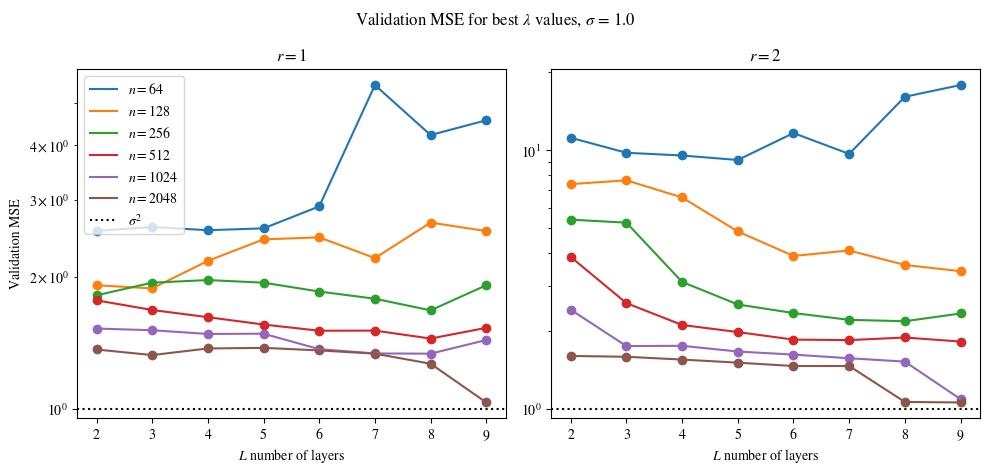

In [118]:
for std in res["sigma"].unique():
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=False, figsize=(10,4.8))
    for rnum,r in enumerate(res.r.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.r == r) * (res.n == n) * (res["sigma"] == std)]
                ax[rnum].scatter(res_rnstd.L,res_rnstd[["Validation MSE"]])
                ax[rnum].semilogy(res_rnstd.L,res_rnstd[["Validation MSE"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
                    # ax[rnum].annotate(text,[model.L,model[["Validation MSE"]]],fontsize=1)
        ax[rnum].set_xlabel("$L$ number of layers")
        ax[rnum].set_title(rf"$r={r}$")
        if std > 0:
            ax[rnum].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation MSE")
        f.suptitle(rf"Validation MSE for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig(job_name+f"_labelnoise{std}/ValidationMSE.pdf",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [248]:
columnwidth = 6.17406722223
markersize = 4
colors = {  
    0   :"C0",
    0.25:"C1",
    0.5 :"C2",
    1   :"C3"
}
labels = {
    "without linear layers":"-",
    "with linear layers"   :"--",
}
markers = {
    "without linear layers":".",
    "with linear layers"   :"x",
}

### generalization

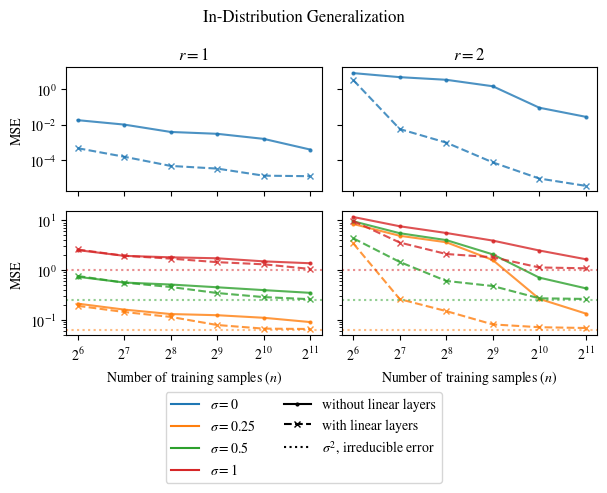

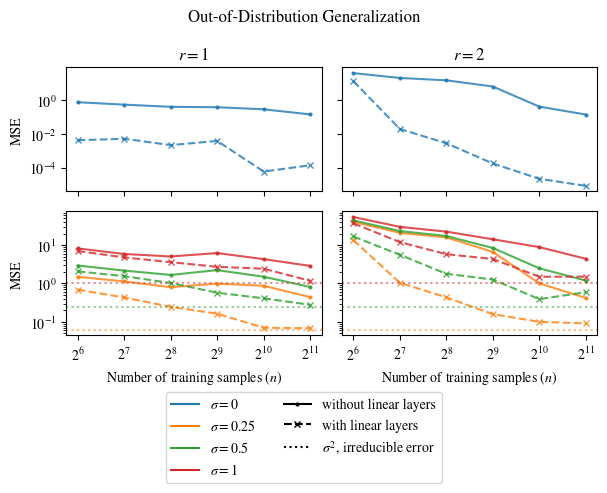

In [249]:
#generalization and OOD errors
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, irreducible error'),
]

for metric in ['In-Distribution Generalization','Out-of-Distribution Generalization']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey="row", figsize=(columnwidth,4))
    #just the data without label noise in the first row
    for col,r in enumerate(res.r.unique()):
        for row,sigmas in enumerate([[0],[0.25,0.5,1]]):
            for sigma in sigmas:
                for label,ls in labels.items():
                    if label == "with linear layers":
                        curr = bestLres[(bestLres.r == r) * (bestLres["sigma"] == sigma)]
                    elif label == "without linear layers":
                        curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                    points = curr[[metric]].values[:,0]
                    # errorbars = curr[[standard_errors]].values[:,0]
                    marker = markers[label]
                    ax[row,col].plot(curr.n,points,
                                        linestyle=ls,
                                        marker=marker,
                                        markersize=markersize,
                                        color=colors[sigma],
                                        alpha=0.8)
                    #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
                    ax[1,col].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
                    # for (_,model),y in zip(curr.iterrows(),points):
                    #     text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                    #     ax[row,col].annotate(text,[model["n"],y],fontsize=1)
            #plot set up
            ax[row,col].set_xscale("log",base=2)
            ax[row,col].set_xticks([2**k for k in range(6,12)])
            ax[row,col].set_yscale("log",base=10)
            ax[row,0].set_ylabel(f"MSE",wrap=True)
            ax[0,col].set_title(rf"$r={r}$") 
            ax[1,col].set_xlabel("Number of training samples ($n$)")
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.04))
    plt.suptitle(f"{metric}")
    plt.tight_layout()
    plt.savefig(job_name+f"{metric}.pdf",dpi=300,bbox_inches='tight')
    plt.show()

### singular values

1 64 0 0
1 128 0 1
1 256 0 2
1 512 1 0
1 1024 1 1
1 2048 1 2
2 64 2 0
2 128 2 1
2 256 2 2
2 512 3 0
2 1024 3 1
2 2048 3 2


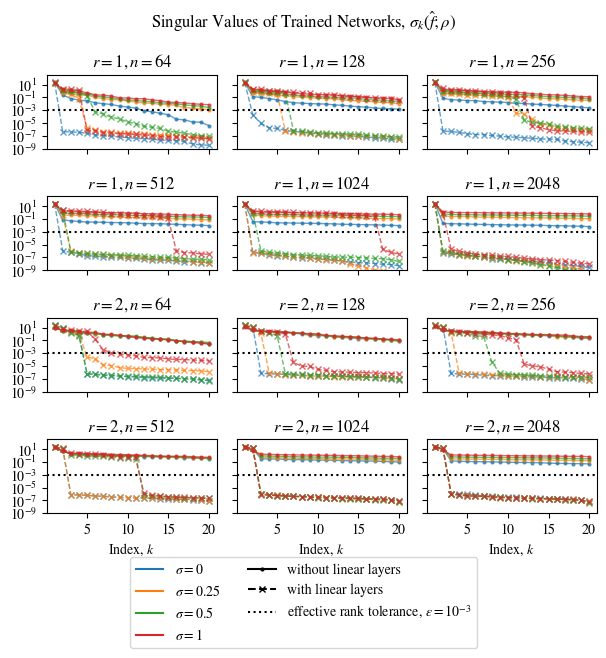

In [250]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [Line2D([0], [0], color='k', ls=':', label=r"effective rank tolerance, $\varepsilon = 10^{-3}$")]

ranktol = 1e-3
f, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(columnwidth,5.75))
for rnum,r in enumerate(res.r.unique()):
    for nnum,n in enumerate(res.n.unique()):
        row = 2*rnum + nnum // 3
        col = nnum % 3
        print(r,n,row,col)
        for sigma in labelnoise:
            for label,ls in labels.items():
                if label == "with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres.n == n) * (bestLres["sigma"] == sigma)]
                elif label == "without linear layers":
                    curr = res[(res.L == 2) * (res.n == n) * (res.r == r) * (res["sigma"]==sigma)]
                marker = markers[label]
                ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),
                    linestyle=ls,
                    linewidth=1,
                    alpha=0.7,
                    marker=marker,
                    markersize=markersize,
                    color=colors[sigma])
        ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = r"effective rank tolerance, $\varepsilon = 10^{-3}$")
        ax[row,col].set_xticks(list(range(4,20,5)),list(range(5,21,5)))
        ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
        ax[row,col].set_title(rf"$r={r},n={n}$")
        ax[-1,col].set_xlabel(rf"Index, $k$")
        ax[row,col].set_ylim(10**(-9),10**(2.5))
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.04))
plt.suptitle(r"Singular Values of Trained Networks, $\sigma_k(\hat{f};\rho)$")
plt.tight_layout()
plt.savefig(job_name+f"_labelnoise_sv.pdf",dpi=300, bbox_inches='tight')
plt.show()
handles.pop()

### active subspaces

In [251]:
"Effective Index Rank, $\varepsilon = 10^{-3}$"
"Principal Angle (Degrees)"
len("Effective Index")

15

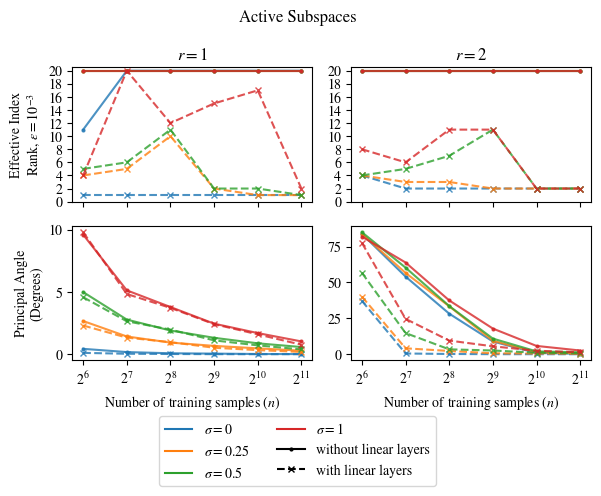

In [252]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 

#active subspace error plot
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey=False, figsize=(columnwidth,4.25))
for row,metric in enumerate([r"Effective Index Rank, $\varepsilon = 10^{-3}$","Principal Angle (Degrees)"]):
    for col,r in enumerate(res.r.unique()):
        for sigma in [0,0.25,0.5,1]:
            for label,ls in labels.items():
                if label == "with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres["sigma"] == sigma)]
                elif label == "without linear layers":
                    curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                if metric == "Principal Angle (Degrees)":
                    points = curr[[metric]].values[:,0]
                elif metric == r"Effective Index Rank, $\varepsilon = 10^{-3}$":
                    points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                    ax[row,col].set_yticks(np.arange(0,21,2))
                    ax[row,col].set_ylim(0,20.5)
                marker = markers[label]
                ax[row,col].plot(curr.n,points,
                                    linestyle=ls,
                                    color=colors[sigma],
                                    marker=marker,
                                    markersize=markersize,
                                    alpha=0.8)
                # for (_,model),y in zip(curr.iterrows(),points):
                #     text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                #     ax[row,col].annotate(text,[model["n"],y],fontsize=1)
        #plot set up
        ax[row,0].set_ylabel(metric[:15] + '\n' + metric[16:])
        ax[0,col].set_title(rf"$r={r}$") 
        ax[row,col].set_xscale("log",base=2)
        ax[row,col].set_xticks([2**k for k in range(6,12)])
        ax[1,col].set_xlabel("Number of training samples ($n$)")
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.04))
plt.suptitle(f"Active Subspaces")
plt.tight_layout()
plt.savefig(job_name+f"Active Subspaces.pdf",dpi=300,bbox_inches='tight')
plt.show()

## Training v Epoch after Tuning $(\lambda, L)$

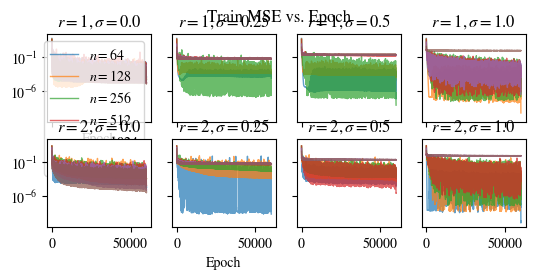

<Figure size 1000x1000 with 0 Axes>

In [124]:
sigmas = np.array([0,0.25,0.5,1])
f, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(columnwidth,2.5))
plt.figure(figsize=(10,10))
for rownum,row in bestLres.iterrows():
    sigma = row['sigma']
    r = row['r']
    whichcol = np.where(sigma == sigmas)[0][0]
    whichrow = 0 if r == 1 else 1
    ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$n = {row['n']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},\sigma = {sigma}$")
    ax[whichrow,whichrow].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle(rf"Train MSE vs. Epoch")
f.savefig(job_name+f"trainmse.pdf",dpi=300)
plt.show()

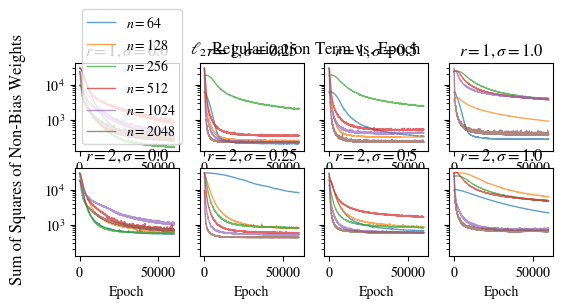

<Figure size 1000x1000 with 0 Axes>

In [125]:
sigmas = np.array([0,0.25,0.5,1])
f, ax = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=True, figsize=(columnwidth,2.5))
plt.figure(figsize=(10,10))
for rownum,row in bestLres.iterrows():
    sigma = row['sigma']
    r = row['r']
    whichcol = np.where(sigma == sigmas)[0][0]
    whichrow = 0 if r == 1 else 1
    ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$n = {row['n']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},\sigma = {sigma}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle(rf"$\ell_2$-Regularization Term vs. Epoch")
f.supylabel(rf"Sum of Squares of Non-Bias Weights")
f.savefig(job_name+f"weightdecay.pdf",dpi=300)
plt.show()